In [1]:
import requests
import json
import datetime
import pandas as pd
import numpy as np
import re
import os
import random
import urllib3
import time
import matplotlib
import nltk

from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score,train_test_split, validation_curve, cross_val_predict
from sklearn.metrics import roc_curve, accuracy_score, recall_score, confusion_matrix,f1_score
from sklearn import tree

In [2]:
path = '../data/us/'

In [3]:
df = pd.read_csv(path + 'US.csv')


In [4]:
df.head()

,Unnamed: 0,title,date,content,source,keyword-trump,keyword-republican,keyword-biden,keyword-democratic,keyword-election
0,0,'Empathy matters': Joe Biden's endorsers highl...,2020-04-15,CNN Nearly every top Democrat says the same t...,cnn,True,True,True,True,False
1,1,Elizabeth Warren endorses Joe Biden for president,2020-04-15,The former 2020 Democratic presidential candid...,cnn,True,False,True,True,True
2,2,"Amid a pandemic, lawmakers urge leadership to ...",2020-04-15,CNN Many rank and file House Democrats are gr...,cnn,False,True,False,True,False
3,3,Stacey Abrams says she would be an 'excellent ...,2020-04-15,Washington CNN Former Georgia gubernatorial ca...,cnn,False,True,True,True,True
4,4,Justin Amash discussing 'potential campaign' f...,2020-04-15,He has been discussing the potential campaign...,cnn,True,True,False,False,True


## preprocess

In [5]:
print(df.source.value_counts())
df["source_num"] = df.source.map({'cnn': 1, 'pbs': 0, 'foxnews': -1})
print(df.source_num.value_counts())


cnn        7327
foxnews    3775
pbs        2135
Name: source, dtype: int64
 1    7327
-1    3775
 0    2135
Name: source_num, dtype: int64


In [6]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)

    
    return string.strip().lower()

In [7]:
# df = df.drop(columns=['Unnamed: 0'])
df['content'] = [clean_str(s) for s in df.content]
df.content.head()

0    cnn nearly every top democrat says the same th...
1    the former democratic presidential candidate t...
2    cnn many rank and file house democrats are gro...
3    washington cnn former georgia gubernatorial ca...
4    he has been discussing the potential campaign ...
Name: content, dtype: object

In [8]:
def undersamples(df):
    # Count the number of observations for each source
    source_counts = df['source'].value_counts()

    # Find the minimum count among the sources
    min_count = source_counts.min()

    # Subset the data to include only observations with the minimum count for each source
    subset_df = df.groupby('source').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
    return subset_df

In [14]:
subset_df = undersamples(df)

In [10]:
republican_df = df[df['keyword-republican']==1]
republican_subset = undersamples(republican_df)

trump_df = df[df['keyword-trump']==1]
trump_subset = undersamples(trump_df)

democratic_df = df[df['keyword-democratic']==1]
democratic_subset = undersamples(democratic_df)

biden_df = df[df['keyword-biden']==1]
biden_subset = undersamples(biden_df)

election_df = df[df['keyword-election']==1]
election_subset = undersamples(election_df)

In [11]:
def get_xy(df):
    x = df['content'].tolist()
    y = df['source_num'].tolist()
    
    stopwordset= set(stopwords.words('english'))
    morestop={'cnn','fox', 'news', 'pbs','subscribe', 'click', 'keyword', 'state', 'said', 'app', 'ap'}
    stopwordset= list(stopwordset.union(morestop))

    vect = TfidfVectorizer(stop_words=stopwordset)
    X = vect.fit_transform(x)
    Y = np.array(y)
    
    return (X, Y, vect)


In [16]:
def generate_evaluate(df):

    (X, y, vect) = get_xy(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    
    evalute_dict = {}
    # create logistic regression model
    # Fit logistic regression model
   
    evalute_dict['knn'] = {}
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    evalute_dict['knn']['preds'] = knn.predict(X_test)
    evalute_dict['knn']['acc'] = accuracy_score(y_test, evalute_dict['knn']['preds'])
    evalute_dict['knn']['f1'] = f1_score(y_test, evalute_dict['knn']['preds'], average='weighted')
    print(f"K Neighbors Classifier: accuracy {evalute_dict['knn']['acc']}/ f1 {evalute_dict['knn']['f1']}" )

    
    # Fit Multinomial Naive Bayes model
    evalute_dict['mnb'] = {}
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    evalute_dict['mnb']['preds'] = mnb.predict(X_test)
    evalute_dict['mnb']['acc'] = accuracy_score(y_test, evalute_dict['mnb']['preds'])
    evalute_dict['mnb']['f1'] = f1_score(y_test, evalute_dict['mnb']['preds'],  average='weighted')
    print(f"Multinomial Naive Bayes: accuracy {evalute_dict['mnb']['acc']}/ f1 {evalute_dict['mnb']['f1']}" )
    
    evalute_dict['svm'] = {}
    svm = SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)
    evalute_dict['svm']['preds'] = svm.predict(X_test)
    evalute_dict['svm']['acc'] = accuracy_score(y_test, evalute_dict['svm']['preds'])
    evalute_dict['svm']['f1'] = f1_score(y_test, evalute_dict['svm']['preds'], average='weighted')
    print(f"Support Vector Machine: accuracy {evalute_dict['svm']['acc']}/ f1 {evalute_dict['svm']['f1']}" )

    # Decision Tree
    evalute_dict['tree'] = {}
    tree = DecisionTreeClassifier(random_state=1234)
    tree.fit(X_train, y_train)
    evalute_dict['tree']['preds'] = tree.predict(X_test)
    evalute_dict['tree']['acc'] = accuracy_score(y_test,evalute_dict['tree']['preds'])
    evalute_dict['tree']['f1'] = f1_score(y_test, evalute_dict['tree']['preds'], average='weighted')
    print(f"Decision Tree: accuracy {evalute_dict['tree']['acc']}/ f1 {evalute_dict['tree']['f1']}" )
   
    return evalute_dict 

## run models

## get all result

In [17]:
subset_table = generate_evaluate(subset_df)

df_table = generate_evaluate(df)

K Neighbors Classifier: accuracy 0.550351288056206/ f1 0.5451467867706501
Multinomial Naive Bayes: accuracy 0.7205308352849337/ f1 0.7206217540647823
Support Vector Machine: accuracy 0.6666666666666666/ f1 0.6643363436401506
Decision Tree: accuracy 0.7088212334113974/ f1 0.7088985524664037
K Neighbors Classifier: accuracy 0.6850453172205438/ f1 0.6738715546666756
Multinomial Naive Bayes: accuracy 0.5513595166163142/ f1 0.4016220900634081
Support Vector Machine: accuracy 0.6858006042296072/ f1 0.6336950385211502
Decision Tree: accuracy 0.774546827794562/ f1 0.7715484862575606


In [18]:
# analysis model 
(X, y) = get_xy(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


evalute_dict['tree'] = {}
df_tree = DecisionTreeClassifier(random_state=2027)
tree.fit(X_train, y_train)
evalute_dict['tree']['preds'] = tree.predict(X_test)
evalute_dict['tree']['acc'] = accuracy_score(y_test,evalute_dict['tree']['preds'])
evalute_dict['tree']['f1'] = f1_score(y_test, evalute_dict['tree']['preds'], average='weighted')
print(f"Decision Tree: accuracy {evalute_dict['tree']['acc']}/ f1 {evalute_dict['tree']['f1']}" )
   

ValueError: too many values to unpack (expected 2)

In [19]:
subset_result = pd.DataFrame(subset_table).T
df_result = pd.DataFrame(df_table).T

subset_result.to_csv(path+ 'subset_result.csv')
df_result.to_csv(path+ 'df_result.csv')

### get keywords' models

In [20]:
republican_subset_table = generate_evaluate(republican_subset)
republican_table = generate_evaluate(republican_df)

K Neighbors Classifier: accuracy 0.5447870778267254/ f1 0.5451962779127796
Multinomial Naive Bayes: accuracy 0.7063142437591777/ f1 0.7085383395712002
Support Vector Machine: accuracy 0.6740088105726872/ f1 0.6750363245499439
Decision Tree: accuracy 0.6945668135095447/ f1 0.6944406647049819
K Neighbors Classifier: accuracy 0.7084450402144772/ f1 0.6969470062371851
Multinomial Naive Bayes: accuracy 0.5831099195710456/ f1 0.43237144836139496
Support Vector Machine: accuracy 0.6823056300268097/ f1 0.619742052416972
Decision Tree: accuracy 0.8002680965147453/ f1 0.7986928148814855


In [21]:
democratic_subset_table = generate_evaluate(democratic_subset)
print('\n')
democratic_table = generate_evaluate(democratic_df)

K Neighbors Classifier: accuracy 0.5722222222222222/ f1 0.5695434805745275
Multinomial Naive Bayes: accuracy 0.7266666666666667/ f1 0.7269997874526464
Support Vector Machine: accuracy 0.6766666666666666/ f1 0.6766935113665429
Decision Tree: accuracy 0.6966666666666667/ f1 0.6965655192326143


K Neighbors Classifier: accuracy 0.6727467811158798/ f1 0.6648623158955824
Multinomial Naive Bayes: accuracy 0.5472103004291845/ f1 0.4044557659680107
Support Vector Machine: accuracy 0.6952789699570815/ f1 0.6515617822094962
Decision Tree: accuracy 0.776824034334764/ f1 0.7756012973771391


In [ ]:
trump_subset_table = generate_evaluate(trump_subset)
trump_table = generate_evaluate(trump_df)

In [ ]:
biden_subset_table = generate_evaluate(biden_subset)
biden_table = generate_evaluate(biden_df)

In [24]:
election_subset_table = generate_evaluate(election_subset)
election_table = generate_evaluate(election_df)

K Neighbors Classifier: accuracy 0.5903490759753593/ f1 0.5904028098884936
Multinomial Naive Bayes: accuracy 0.7248459958932238/ f1 0.7226987219348795
Support Vector Machine: accuracy 0.6827515400410678/ f1 0.6829618122812482
Decision Tree: accuracy 0.6745379876796714/ f1 0.6743279804741135
K Neighbors Classifier: accuracy 0.6971655892590751/ f1 0.6884723459802465
Multinomial Naive Bayes: accuracy 0.5977125808055693/ f1 0.45046561953609987
Support Vector Machine: accuracy 0.6872202884137245/ f1 0.625878133747446
Decision Tree: accuracy 0.7797115862754849/ f1 0.7789783998627547


In [25]:
election_subset_result = pd.DataFrame(election_subset_table).T
election_result = pd.DataFrame(election_table).T

biden_subset_result = pd.DataFrame(biden_subset_table).T
biden_result = pd.DataFrame(biden_table).T

trump_subset_result = pd.DataFrame(trump_subset_table).T
trump_result = pd.DataFrame(trump_table).T

republican_subset_result = pd.DataFrame(republican_subset_table).T
republican_result = pd.DataFrame(republican_table).T

democratic_subset_result = pd.DataFrame(democratic_subset_table).T
democratic_result = pd.DataFrame(democratic_table).T

In [45]:
election_subset_result.to_csv(path+ 'election_subset_result.csv')
election_result.to_csv(path+ 'election_result.csv')

biden_subset_result.to_csv(path+ 'biden_subset_result.csv')
biden_result.to_csv(path+ 'biden_result.csv')

trump_subset_result.to_csv(path+ 'trump_subset_result.csv')
trump_result.to_csv(path+ 'trump_result.csv')

republican_subset_result.to_csv(path+ 'republican_subset_result.csv')
republican_result.to_csv(path+ 'republican_result.csv')

democratic_subset_result.to_csv(path+ 'democratic_subset_result.csv')
democratic_result.to_csv(path+ 'democratic_result.csv')

## evaluate tree

In [89]:
# analysis model 
(X, y, vect) = get_xy(cnn_fox)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


df_tree = DecisionTreeClassifier(random_state=2027)
df_tree.fit(X_train, y_train)


DecisionTreeClassifier(random_state=2027)

[Text(0.5, 0.875, 'x[12964] <= 0.004\ngini = 0.45\nsamples = 8881\nvalue = [3032, 5849]'),
 Text(0.25, 0.625, 'x[18082] <= 0.012\ngini = 0.497\nsamples = 4552\nvalue = [2458, 2094]'),
 Text(0.125, 0.375, 'x[9271] <= 0.004\ngini = 0.454\nsamples = 2197\nvalue = [766, 1431]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'x[24857] <= 0.002\ngini = 0.405\nsamples = 2355\nvalue = [1692, 663]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'x[32419] <= 0.003\ngini = 0.23\nsamples = 4329\nvalue = [574, 3755]'),
 Text(0.625, 0.375, 'x[9271] <= 0.004\ngini = 0.165\nsamples = 4055\nvalue = [368, 3687]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'x[15455] <= 0.017\ngini = 0.373\nsamples = 274\nvalue = [206, 68]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

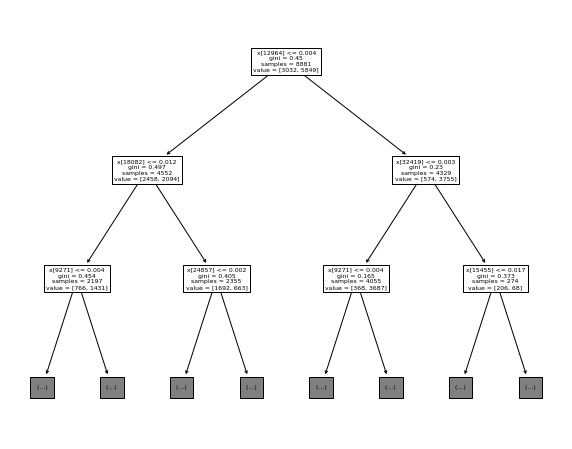

In [90]:
plt.figure(figsize=(10, 8))
plot_tree(df_tree,
          max_depth = 2)

In [56]:
vect.get_feature_names_out()[37030]

'press'

### get sources

#### CNN VS PBS


In [30]:
def get_2news(data, except_num):
    return data[data.source_num!=except_num]

cnn_pbs = get_2news(df, -1)
cnn_pbs_subset = get_2news(subset_df, -1)

In [49]:
cnn_pbs_dict = generate_evaluate(cnn_pbs)
cnn_pbs_result = pd.DataFrame(cnn_pbs_dict).T
cnn_pbs_result.to_csv(path+ 'cnn_pbs_result.csv')

KeyboardInterrupt: 

In [35]:
cnn_pbs_trump_dict = generate_evaluate(cnn_pbs_trump)
cnn_pbs_trump_result = pd.DataFrame(cnn_pbs_trump_dict).T
cnn_pbs_trump_result.to_csv(path+ 'cnn_pbs_trump_result.csv')

K Neighbors Classifier: accuracy 0.8137573004542504/ f1 0.7979450985157795
Multinomial Naive Bayes: accuracy 0.7890979883192732/ f1 0.6960777321699211
Support Vector Machine: accuracy 0.8234912394548994/ f1 0.7696030852922202
Decision Tree: accuracy 0.8799480856586632/ f1 0.8773835788558233


In [36]:
cnn_pbs_trump_subset_dict = generate_evaluate(cnn_pbs_trump_subset)
cnn_pbs_trump_subset_result = pd.DataFrame(cnn_pbs_trump_subset_dict).T
cnn_pbs_trump_subset_result.to_csv(path+ 'cnn_pbs_trump_subset_result.csv')


K Neighbors Classifier: accuracy 0.6799387442572741/ f1 0.6795332850286229
Multinomial Naive Bayes: accuracy 0.8085758039816233/ f1 0.8085093610967478
Support Vector Machine: accuracy 0.7672281776416539/ f1 0.7659252195406603
Decision Tree: accuracy 0.8300153139356815/ f1 0.8298640011654093


In [37]:
cnn_pbs_dem_dict = generate_evaluate(cnn_pbs_dem)
cnn_pbs_dem_result = pd.DataFrame(cnn_pbs_dem_dict).T
cnn_pbs_dem_result.to_csv(path+ 'cnn_pbs_dem_result.csv')

K Neighbors Classifier: accuracy 0.80234375/ f1 0.7883130639281084
Multinomial Naive Bayes: accuracy 0.7546875/ f1 0.6491790961709706
Support Vector Machine: accuracy 0.79609375/ f1 0.7374383672528287
Decision Tree: accuracy 0.86796875/ f1 0.8660751106289368


In [38]:
# cnn_pbs_dem_subset_dict = generate_evaluate(cnn_pbs_dem_subset)
# cnn_pbs_dem_subset_result = pd.DataFrame(cnn_pbs_dem_subset_dict).T
# cnn_pbs_dem_subset_result.to_csv(path+ 'cnn_pbs_dem_subset_result.csv')

K Neighbors Classifier: accuracy 0.6733333333333333/ f1 0.6735294117647059
Multinomial Naive Bayes: accuracy 0.8133333333333334/ f1 0.813445434224135
Support Vector Machine: accuracy 0.7883333333333333/ f1 0.788004507671657
Decision Tree: accuracy 0.8083333333333333/ f1 0.8083998888811722


In [39]:
cnn_pbs_biden_dict = generate_evaluate(cnn_pbs_biden)
cnn_pbs_biden_result = pd.DataFrame(cnn_pbs_biden_dict).T
cnn_pbs_biden_result.to_csv(path+ 'cnn_pbs_biden_result.csv')

K Neighbors Classifier: accuracy 0.8098039215686275/ f1 0.7929997845291963
Multinomial Naive Bayes: accuracy 0.7901960784313725/ f1 0.6975882138178383
Support Vector Machine: accuracy 0.8186274509803921/ f1 0.7601358091983312
Decision Tree: accuracy 0.8892156862745098/ f1 0.8868491757332676


In [40]:
# cnn_pbs_biden_subset_dict = generate_evaluate(cnn_pbs_biden_subset)
# cnn_pbs_biden_subset_result = pd.DataFrame(cnn_pbs_biden_subset_dict).T
# cnn_pbs_biden_subset_result.to_csv(path+ 'cnn_pbs_biden_subset_result.csv')

K Neighbors Classifier: accuracy 0.6899766899766899/ f1 0.6894027009142915
Multinomial Naive Bayes: accuracy 0.7878787878787878/ f1 0.7878672618697721
Support Vector Machine: accuracy 0.7622377622377622/ f1 0.7622145069328169
Decision Tree: accuracy 0.7995337995337995/ f1 0.7993920672088093


In [41]:
cnn_pbs_election_dict = generate_evaluate(cnn_pbs_election)
cnn_pbs_election_result = pd.DataFrame(cnn_pbs_election_dict).T
cnn_pbs_election_result.to_csv(path+ 'cnn_pbs_election_result.csv')

K Neighbors Classifier: accuracy 0.8100671140939597/ f1 0.7964763374043107
Multinomial Naive Bayes: accuracy 0.7798657718120805/ f1 0.6840891324285018
Support Vector Machine: accuracy 0.8093959731543624/ f1 0.7482401880431757
Decision Tree: accuracy 0.876510067114094/ f1 0.872901977769762


In [42]:
cnn_pbs_election_subset_dict = generate_evaluate(cnn_pbs_election_subset)
cnn_pbs_election_subset_result = pd.DataFrame(cnn_pbs_election_subset_dict).T
cnn_pbs_election_subset_result.to_csv(path+ 'cnn_pbs_election_subset_result.csv')

K Neighbors Classifier: accuracy 0.6579352850539292/ f1 0.6591214053054354
Multinomial Naive Bayes: accuracy 0.7966101694915254/ f1 0.7971174539005293
Support Vector Machine: accuracy 0.7103235747303543/ f1 0.7059175603345387
Decision Tree: accuracy 0.8135593220338984/ f1 0.8140855552554427


#### cnn fox

In [88]:
cnn_fox = get_2news(df, 0)
cnn_fox_subset = get_2news(subset_df, 0)

In [ ]:
cnn_fox_dict = generate_evaluate(cnn_fox)
cnn_fox_result = pd.DataFrame(cnn_fox_dict).T
cnn_fox_result.to_csv(path+ 'cnn_fox_result.csv')

In [ ]:
cnn_fox_subset_dict = generate_evaluate(cnn_fox_subset)
cnn_fox_subset_result = pd.DataFrame(cnn_fox_subset_dict).T
cnn_fox_subset_result.to_csv(path+ 'cnn_fox_subset_result.csv')

#### fox pbs

In [ ]:
fox_pbs = get_2news(df, 1)
fox_pbs_subset = get_2news(subset_df, 1)

In [ ]:
fox_pbs_dict = generate_evaluate(fox_pbs)
fox_pbs_result = pd.DataFrame(fox_pbs_dict).T
fox_pbs_result.to_csv(path+ 'fox_pbs_result.csv')

In [ ]:
fox_pbs_subset_dict = generate_evaluate(fox_pbs_subset)
fox_pbs_subset_result = pd.DataFrame(fox_pbs_subset_dict).T
fox_pbs_subset_result.to_csv(path+ 'fox_pbs_subset_result.csv')

## analysis

### read in datas and form data table

#### source

In [57]:
# generate mean
def get_avg(data):

    data.loc['mean'] = [None, data['acc'].mean(), data['f1'].mean()]
    return data

In [59]:

df_result = get_avg(pd.read_csv(path+ 'df_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))

cnn_fox_result = get_avg(pd.read_csv(path+ 'cnn_fox_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
fox_pbs_result = get_avg(pd.read_csv(path+ 'fox_pbs_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
cnn_pbs_result = get_avg( pd.read_csv(path+ 'cnn_pbs_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))

subset_result = get_avg(pd.read_csv(path+ 'subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))

cnn_fox_subset_result = get_avg(pd.read_csv(path+ 'cnn_fox_subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
fox_pbs_subset_result = get_avg(pd.read_csv(path+ 'fox_pbs_subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
cnn_pbs_subset_result = get_avg(pd.read_csv(path+ 'cnn_pbs_subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))


df_result['acc'].mean()
subset_result['acc'].mean()

0.6615925058548009

In [87]:
fox_pbs_result

,preds,acc,f1
model,,,
knn,[-1 0 -1 ... -1 -1 -1],0.752961,0.753482
mnb,[-1 -1 -1 ... -1 -1 -1],0.664129,0.546894
svm,[-1 -1 -1 ... -1 -1 -1],0.744501,0.700520
tree,[-1 0 -1 ... -1 -1 -1],0.925550,0.925209
mean,NaN,0.771785,0.731526


In [60]:
models_list = []

models = ['knn', 'mnb', 'svm', 'tree', 'mean']

for m in models:
    model_df = pd.DataFrame()
    model_df.attrs['name'] = m
    
    model_df['whole data'] = df_result.loc[m, ['acc', 'f1']]
    model_df['CNN vs FOX'] = cnn_fox_result.loc[m, ['acc', 'f1']]
    model_df['FOX vs PBS'] = fox_pbs_result.loc[m, ['acc', 'f1']]
    model_df['CNN vs PBS'] = cnn_pbs_result.loc[m, ['acc', 'f1']]
    
    models_list.append(model_df)

In [61]:


sub_models_list = []

models = ['knn', 'mnb', 'svm', 'tree', 'mean']

for m in models:
    model_df = pd.DataFrame()
    model_df.attrs['name'] = m
    
    model_df['whole data'] = subset_result.loc[m, ['acc', 'f1']]
    model_df['CNN vs FOX'] = cnn_fox_subset_result.loc[m, ['acc', 'f1']]
    model_df['FOX vs PBS'] = fox_pbs_subset_result.loc[m, ['acc', 'f1']]
    model_df['CNN vs PBS'] = cnn_pbs_subset_result.loc[m, ['acc', 'f1']]
    
    sub_models_list.append(model_df)
    
    
sub_models_list[0]

,whole data,CNN vs FOX,FOX vs PBS,CNN vs PBS
acc,0.550351,0.762295,0.722482,0.677986
f1,0.545147,0.761878,0.722157,0.678054


#### keywords

In [77]:
election_result = get_avg(pd.read_csv(path+ 'election_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
biden_result = get_avg(pd.read_csv(path+ 'biden_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
trump_result =get_avg( pd.read_csv(path+ 'trump_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
republican_result = get_avg(pd.read_csv(path+ 'republican_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
democratic_result = get_avg( pd.read_csv(path+ 'democratic_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))


election_subset_result = get_avg(pd.read_csv(path+ 'cnn_fox_subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
biden_subset_result =get_avg( pd.read_csv(path+ 'biden_subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
trump_subset_result = get_avg(pd.read_csv(path+ 'trump_subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
republican_subset_result = get_avg( pd.read_csv(path+ 'republican_subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
democratic_subset_result = get_avg(pd.read_csv(path+ 'democratic_subset_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))


In [84]:
subset_result

,preds,acc,f1
model,,,
knn,[-1 0 -1 ... -1 1 -1],0.550351,0.545147
mnb,[-1 0 -1 ... 1 1 0],0.720531,0.720622
svm,[-1 0 -1 ... -1 0 0],0.666667,0.664336
tree,[ 1 -1 -1 ... 0 1 1],0.708821,0.708899
mean,NaN,0.661593,0.659751


In [63]:
keywords_models_list = []

models = ['knn', 'mnb', 'svm', 'tree', 'mean']

for m in models:
    model_df = pd.DataFrame()
    model_df.attrs['name'] = m
    
    model_df['whole data'] = df_result.loc[m, ['acc', 'f1']]
    model_df['election'] = election_result.loc[m, ['acc', 'f1']]
    model_df['Trump'] = trump_result.loc[m, ['acc', 'f1']]
    model_df['Biden'] = biden_result.loc[m, ['acc', 'f1']]
    model_df['Democra'] = democratic_result.loc[m, ['acc', 'f1']]
    model_df['Republican'] = republican_result.loc[m, ['acc', 'f1']]
    
    keywords_models_list.append(model_df)
    
keywords_models_list[0]

,whole data,election,Trump,Biden,Democra,Republican
acc,0.685045,0.697166,0.700706,0.677305,0.672747,0.708445
f1,0.673872,0.688472,0.690426,0.668624,0.664862,0.696947


In [70]:


sub_keywords_models_list = []

models = ['knn', 'mnb', 'svm', 'tree','mean']

for m in models:
    model_df = pd.DataFrame()
    model_df.attrs['name'] = m
    
    model_df['whole data'] = subset_result.loc[m, ['acc', 'f1']]
    model_df['election'] = election_subset_result.loc[m, ['acc', 'f1']]
    model_df['Trump'] = trump_subset_result.loc[m, ['acc', 'f1']]
    model_df['Biden'] = biden_subset_result.loc[m, ['acc', 'f1']]
    model_df['Republican'] = republican_subset_result.loc[m, ['acc', 'f1']]
    model_df['Democratic'] = democratic_subset_result.loc[m, ['acc', 'f1']]
    
    sub_keywords_models_list.append(model_df)
    
sub_keywords_models_list[0]

,whole data,election,Trump,Biden,Republican,Democratic
acc,0.550351,0.762295,0.579162,0.55521,0.544787,0.572222
f1,0.545147,0.761878,0.579196,0.553123,0.545196,0.569543


### show graphs

#### functions

In [71]:

def bars_2data(df1, df2):
    name = df1.attrs["name"] 
    # create a bar plot comparing the 'acc' values of the two data frames
    print(name)
    fig, ax = plt.subplots()
    bar_width = 0.35
    opacity = 0.8

    index = range(len(df1.columns))
    rects1 = ax.bar(index, df1.loc['acc'], bar_width, alpha=opacity, color='b', label='Whole Dataset')
    rects2 = ax.bar([i + bar_width for i in index], df2.loc['acc'], bar_width, alpha=opacity, color='g', label='Undersample')

    ax.set_xlabel('Columns')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0,1)
    # ax.set_title(f'Accuracy of {name} model')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(df1.columns)
    ax.legend()

    # plt.figure(figsize=(20,8))
    fig.set_dpi(100)
    plt.tight_layout()
    plt.show()

In [72]:
def show_bar(data):
    # create the bar plot
    name = data.attrs["name"] 
    print(name)
    bar_width = 0.35
    index = range(len(data.columns))
    
    fig, ax = plt.subplots()
    fig.set_dpi(100)
    
    ax.bar(index, data.loc['acc'],  bar_width , color=['blue', 'orange', 'green', 'red'])
    # ax = .plot(kind='bar', figsize=(12, 10))
    ax.set_ylabel('Accuracy')

    # ax.set_title(f'Accuracy of {name} model')
    
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(data.columns)
    plt.figure(figsize=(12,10))
    
    plt.show()
    


#### shoe viz

mean


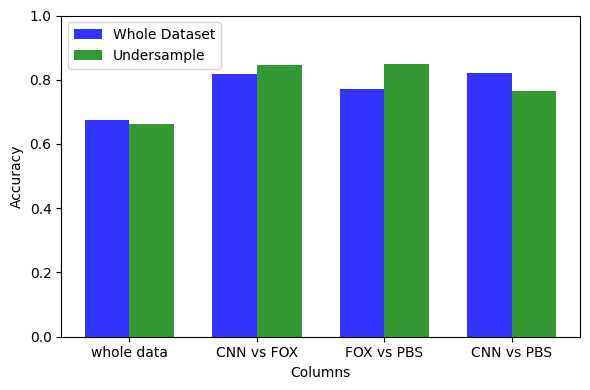

In [73]:
bars_2data(models_list[4], sub_models_list[4])

knn


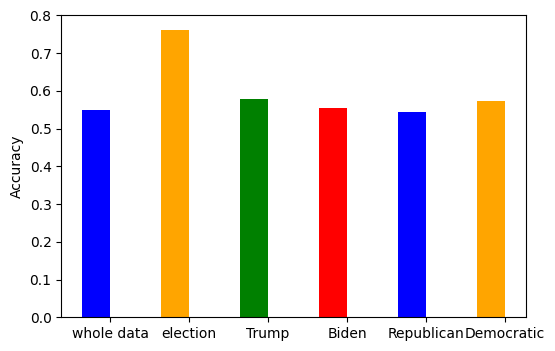

<Figure size 864x720 with 0 Axes>

mnb


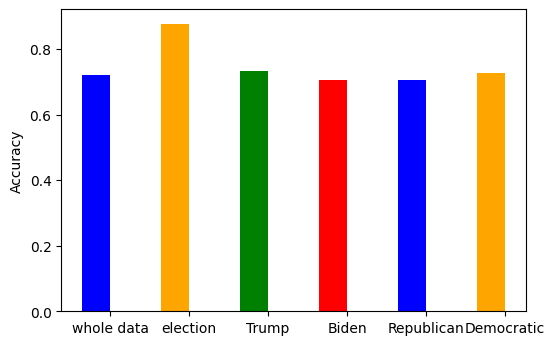

<Figure size 864x720 with 0 Axes>

svm


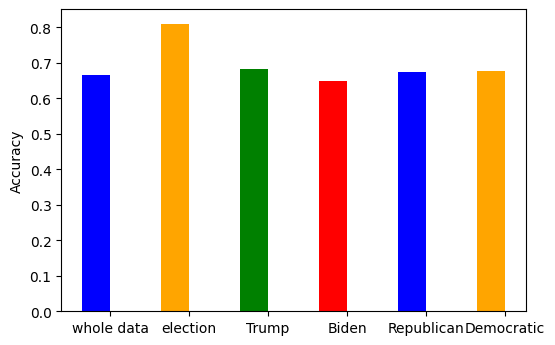

<Figure size 864x720 with 0 Axes>

tree


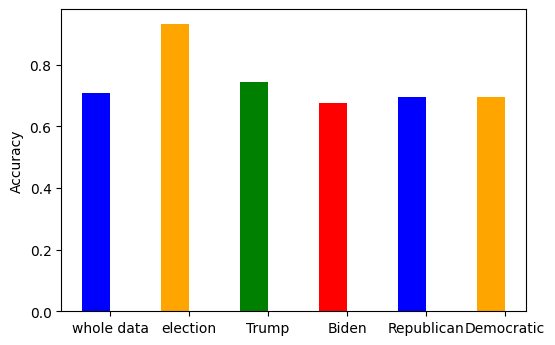

<Figure size 864x720 with 0 Axes>

mean


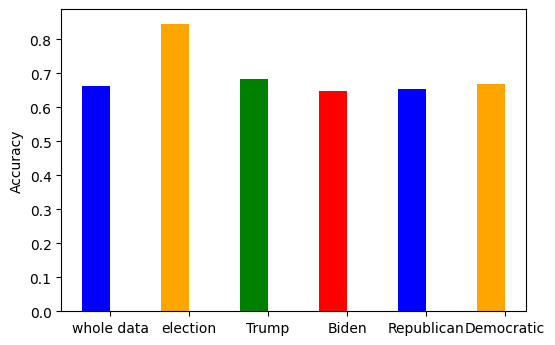

<Figure size 864x720 with 0 Axes>

In [74]:
for i in range(5):
    show_bar(sub_keywords_models_list[i])

knn


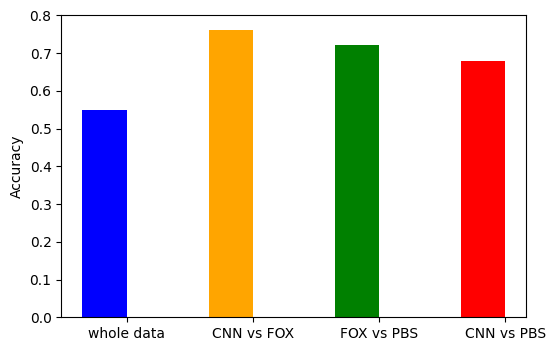

<Figure size 864x720 with 0 Axes>

mnb


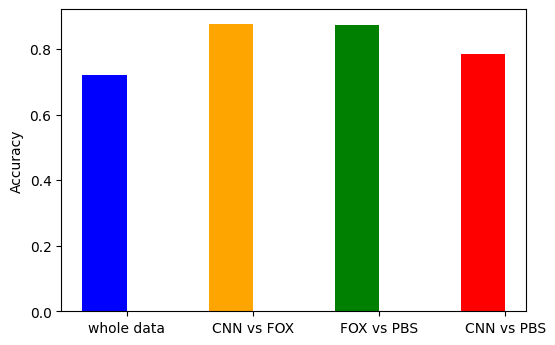

<Figure size 864x720 with 0 Axes>

svm


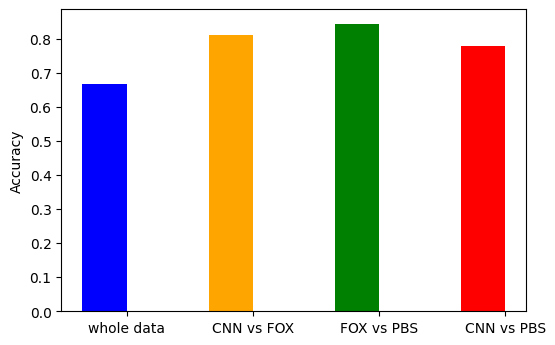

<Figure size 864x720 with 0 Axes>

tree


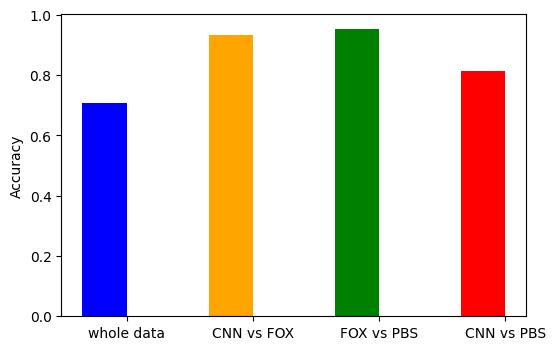

<Figure size 864x720 with 0 Axes>

mean


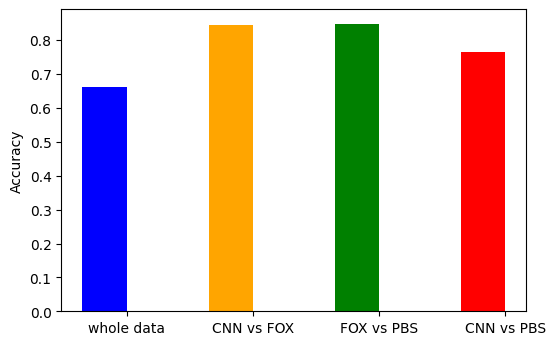

<Figure size 864x720 with 0 Axes>

In [75]:
for i in range(5):
    show_bar(sub_models_list[i])

knn


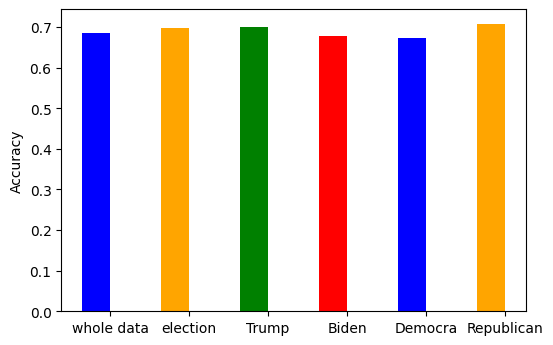

<Figure size 864x720 with 0 Axes>

In [76]:
show_bar(keywords_models_list[0])

In [ ]:
for i in range(4):
    bars_2data(models_list[i], sub_models_list[i])

In [ ]:
for i in range(4):
    bars_2data(keywords_models_list[i], sub_keywords_models_list[i])